In [2]:
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def load_titanic():
    df = sns.load_dataset('titanic')
    df['age'] = df['age'].fillna(df['age'].mean())
    df['class'] = df['class'].map({'First': 1, 'Second': 2, 'Third': 3})
    df['female'] = df['sex'] == 'female'
    X = df[['age', 'class', 'fare', 'female']]
    y = df['survived']
    return X, y

X, y = load_titanic()

In [3]:
X.head()

,age,class,fare,female
0,22.0,3,7.2500,False
1,38.0,1,71.2833,True
2,26.0,3,7.9250,True
3,35.0,1,53.1000,True
4,35.0,3,8.0500,False


In [4]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [5]:
X.shape, y.shape

((891, 4), (891,))

### Naive majority class baseline

In [6]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

### Logistic Regression

In [21]:
lr = LogisticRegression(solver='lbfgs')
cross_val_score(lr, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.7877095 , 0.78212291, 0.78651685, 0.7752809 , 0.80225989])

In [11]:
import pandas as pd

lr.fit(X, y)
pd.Series(lr.coef_[0], X.columns)

age      -0.032595
class    -1.112937
fare      0.000805
female    2.512794
dtype: float64

In [13]:
pd.DataFrame(lr.predict_proba(X), columns=['Not Survived', 'Survived']).head()

,Not Survived,Survived
0,0.887302,0.112698
1,0.099283,0.900717
2,0.420801,0.579199
3,0.092091,0.907909
4,0.923195,0.076805


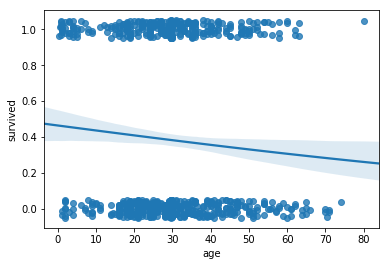

In [16]:
sns.regplot(x=X['age'], y=y, logistic=True, y_jitter=0.05)

### Gradient Boosting

In [19]:
gb = GradientBoostingClassifier()

cross_val_score(gb, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.80446927, 0.82681564, 0.85393258, 0.83146067, 0.84745763])

In [22]:
gb.fit(X, y)
pd.Series(gb.feature_importances_, X.columns)

age       0.131443
class     0.173294
fare      0.199955
female    0.495308
dtype: float64

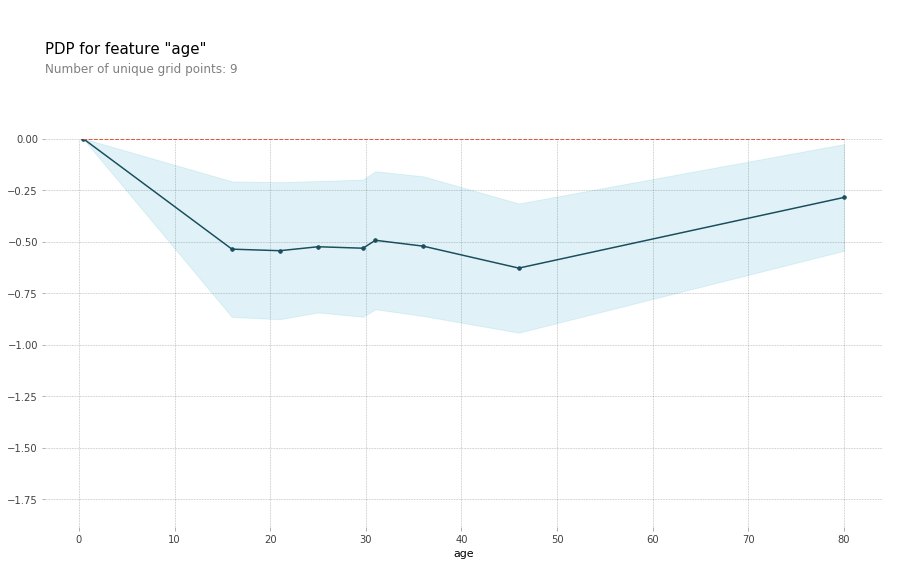

In [23]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'age'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

### Compare Predictions

In [26]:
from sklearn.model_selection import cross_val_predict

y_pred_lr = cross_val_predict(lr, X, y, cv=5, n_jobs=-1)
y_pred_gb = cross_val_predict(gb, X, y, cv=5, n_jobs=-1)

preds = pd.DataFrame({'true': y, 'lr': y_pred_lr, 'gb': y_pred_gb})

gb_right = preds['gb'] == preds['true']
lr_wrong = preds['lr'] != preds['true']

In [27]:
len(preds[gb_right & lr_wrong]) / len(preds)

0.08417508417508418

In [33]:
# All the instances where gradient boosting correctly predicted y AND logistic regression predicted wrong

preds[gb_right & lr_wrong].head()

,true,lr,gb
27,0,1,0
64,0,1,0
71,0,1,0
74,1,0,1
78,1,0,1


In [37]:
data_for_prediction = X.loc[27]

data_for_prediction

age          19
class         1
fare        263
female    False
Name: 27, dtype: object

### Explain individual prediction

In [38]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [39]:
import category_encoders as ce
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Load data from https://www.kaggle.com/c/ds1-tree-ensembles/data
X_train = pd.read_csv('train_features.csv')
X_test = pd.read_csv('test_features.csv')
y_train = pd.read_csv('train_labels.csv')['charged_off']
sample_submission = pd.read_csv('sample_submission.csv')


def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [40]:
%%time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_proba = gb.predict_proba(X_val)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC: 0.7441661221108131
CPU times: user 16.3 s, sys: 231 ms, total: 16.6 s
Wall time: 16.2 s


In [53]:
y_train.value_counts(normalize=True)

0    0.852861
1    0.147139
Name: charged_off, dtype: float64

### Partial Dependence Plot

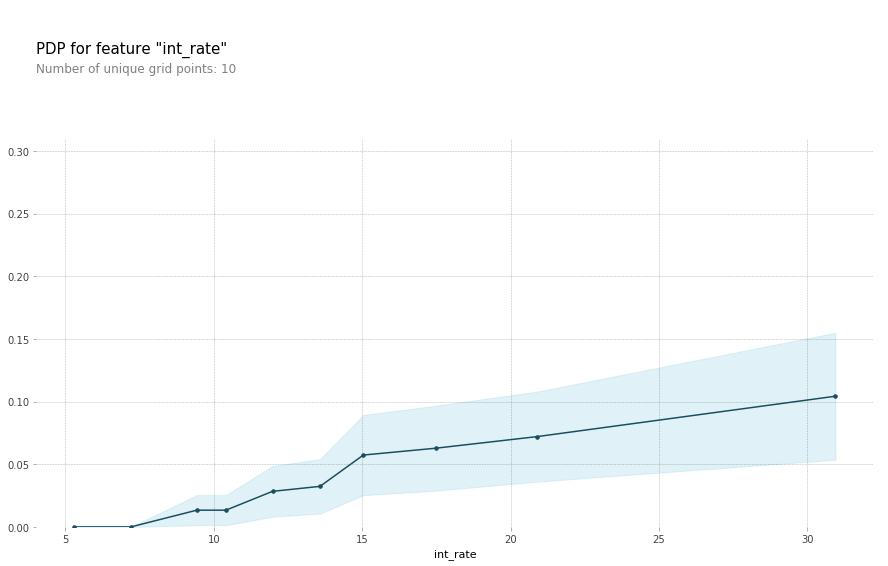

In [55]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='int_rate'
pdp_isolated = pdp_isolate(model=gb, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

### Individual predictions

In [56]:
import numpy as np
y_pred = (y_pred_proba >= 0.5).astype(int)
confidence = np.abs(y_pred_proba - 0.5)
preds = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba, 'confidence': confidence})

In [57]:
# True positives, with high confidence

preds[(y_val==1) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
17575,1,1,0.803640,0.303640
36032,1,1,0.784028,0.284028
24134,1,1,0.775933,0.275933
13765,1,1,0.765269,0.265269
24768,1,1,0.758786,0.258786


In [61]:
data_for_prediction = X_val.loc[17575]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [66]:
# True negatives, with high confidence
preds[(y_val==0) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
29029,0,0,0.014921,0.485079
1778,0,0,0.017428,0.482572
23855,0,0,0.019234,0.480766
21604,0,0,0.019572,0.480428
32965,0,0,0.019754,0.480246


In [68]:
data_for_prediction = X_val.loc[1778]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [62]:
# False positives, with high (mistaken) confidence
preds[(y_val==0) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
33542,0,1,0.893203,0.393203
9560,0,1,0.712540,0.212540
15711,0,1,0.698724,0.198724
11486,0,1,0.696137,0.196137
34640,0,1,0.688740,0.188740


In [63]:
data_for_prediction = X_val.loc[33542]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [64]:
# False negatives, with high (mistaken) confidence
preds[(y_val==1) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
30492,1,0,0.021897,0.478103
22307,1,0,0.028285,0.471715
5743,1,0,0.029774,0.470226
23226,1,0,0.032316,0.467684
10300,1,0,0.036592,0.463408


In [65]:
data_for_prediction = X_val.loc[30492]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [70]:
# Most uncertain predictions (least confidence)
preds.sort_values(by='confidence', ascending=True).head()

,y_val,y_pred,y_pred_proba,confidence
33095,0,0,0.499459,0.000541
25617,1,0,0.498327,0.001673
17698,1,1,0.501813,0.001813
15538,1,1,0.501889,0.001889
36197,0,0,0.495927,0.004073


In [71]:
data_for_prediction = X_val.loc[33095]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)